## Import Libraries

In [43]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

-------------------------------------------------------------------------------------------------------------------------------

## Load and Inspect Data

In [2]:
data = pd.read_csv("insurance.txt")
data.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   charges   1338 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 41.9 KB


In [4]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


-------------------------------------------------------------------------------------------------------------------------------

## Preprocess Data

__The purpose of the following preprocessing is to demonstrate that the employed method is functioning correctly. However, while building regression models, the training and testing datasets are standardised separately to prevent data leakage.__

In [5]:
column_names = list(data.columns)
standardize = lambda x : (x - x.mean()) / x.std() 

__Standardize Data__

In [6]:
for column in column_names:
    data[column] = standardize(data[column])

In [8]:
data.mean()

age        -1.246304e-16
bmi        -1.810543e-16
children   -3.116590e-16
charges    -7.218939e-17
dtype: float64

Although standardised mean should be equal to 0, in reality they are infinitesimally close to zero. Double precision floats have 53 bits or 16 digits of precision, so this is expected behavior.

In [9]:
data.std()

age         1.0
bmi         1.0
children    1.0
charges     1.0
dtype: float64

In [10]:
x1, x2, x3, y = data["age"], data["bmi"], data["children"], data["charges"]

-------------------------------------------------------------------------------------------------------------------------------

## Visualize Data

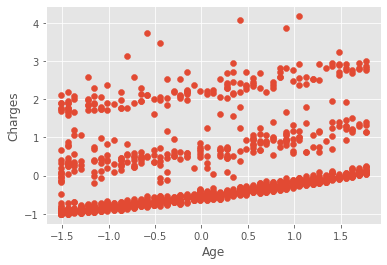

In [11]:
plt.scatter(x1, y)
plt.xlabel("Age")
plt.ylabel("Charges");

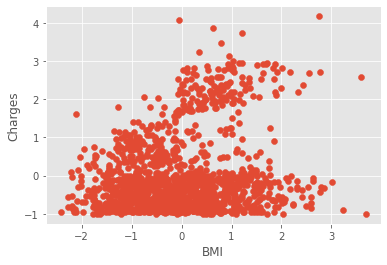

In [12]:
plt.scatter(x2, y)
plt.xlabel("BMI")
plt.ylabel("Charges");

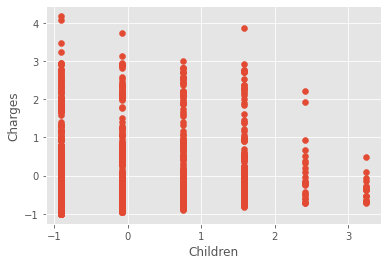

In [13]:
plt.scatter(x3, y)
plt.xlabel("Children")
plt.ylabel("Charges");

-------------------------------------------------------------------------------------------------------------------------------

## Linear Regression Algorithms

### Linear Regression by Solving Normal Equations

$y = w_{0} + w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{3}$

$x_{1}, x_{2}, x_{3}$ represent the age, bmi and number of children respectively. $ w_{1},w_{2}, w_{3}$ are weights associated with $x_{1}, x_{2}, x_{3}$.

$$X = 
\begin{bmatrix} 
1 & x_{11} & x_{12} & x_{13}\\
1 & x_{21} & x_{22} & x_{23}\\
. & . & . & . \\
. & . & . & . \\
1 & x_{m1} & x_{m2} & x_{m3}\\
\end{bmatrix}
\quad
$$
$$ $$
$$Y = 
\begin{bmatrix} 
y_{1}\\
y_{2}\\
.\\
.\\
y_{m}\\
\end{bmatrix}
\quad
$$ where $m$ = size of training data
$$ $$
$$ω = 
\begin{bmatrix} 
ω_{0}\\
ω_{1}\\
ω_{2}\\
ω_{3}\\
\end{bmatrix}
\quad
$$
$$ $$
$$b = X^{T} . Y$$

$$ ω = (X^{T}.X)^{-1}x^{T}.Y = (X^{T}.X)^{-1}.b$$

In [14]:
class NE:
    def __init__(self, data):
        self.data = data
        self.models = pd.DataFrame(columns = ["w0", "w1", "w2", "w3", "testing_error", "training_error"])
        self.model = np.zeros((4, 1))
        self.min_error = float("inf")
    
    # shuffles data randomly
    def __shuffle(self):
        self.data = self.data.sample(frac = 1)
    
    # splits a data frame in 70:30 ratio
    def __split(self):
        train = self.data[:int(0.7 * len(data))]
        test = self.data[int(0.7 * len(data)):]
        return train, test
    
    # standardizes data
    def __standardize(self, data):
        column_names = list(data.columns)
        standardize = lambda x : (x - x.mean()) / x.std()
        for column in column_names:
            data[column] = standardize(data[column])
        return data
    
    # computes and returns X and Y matrices
    def __matrices(self, train):
        x1, x2, x3, y = train["age"], train["bmi"], train["children"], train["charges"]
        x1, x2, x3= np.array(x1), np.array(x2), np.array(x3)
        Y = np.array(y)
        n = len(Y)
        Y = Y.reshape((n, 1))
        x0 = np.ones((n,1))
        x1 = np.reshape(x1, (n, 1))
        x2 = np.reshape(x2, (n, 1))
        x3 = np.reshape(x3, (n, 1))
        X = np.append(x0, x1, axis=1)
        X = np.append(X, x2, axis=1)
        X = np.append(X, x3, axis=1)
        return X, Y
    
    # calculates Mean Square Error
    def __error(self, X, Y, w):
        Y_pred = np.dot(X, w)
        mse = (1/2) * np.average((Y_pred-Y)**2)
        return float(mse)
    
    # tests the model against testing data
    def __testModel(self, test, w):
        Xt, Yt = self.__matrices(test)
        testing_error = self.__error(Xt, Yt, w)
        return testing_error
    
    # main function to build models
    def buildModels(self, number = 20):
        for i in range(number):
            # shuffle dataset
            self.__shuffle()
            # split dataset
            train, test = self.__split()
            # standardise training and testing data
            train = self.__standardize(train)
            test = self.__standardize(test)
            # obtain X and Y matrices
            X, Y = self.__matrices(train)
            # obtain the best-fit model weights
            w = self.__solve(X, Y)
            # calculate training error
            training_error = self.__error(X, Y, w)
            # calculate testing error
            testing_error = self.__testModel(test, w)
            # append the model, errors to models dataframe
            model = list(w)
            model.append(testing_error)
            model.append(training_error)
            model = pd.Series(model, index = self.models.columns)
            # the model with least testing error is accepted as the final model
            self.models = self.models.append(model, ignore_index=True)
            if self.min_error > testing_error:
                self.min_error = testing_error
                self.model = w

    #_____________________________________________________________________#           
    # solves normal equations and returns corresponding regression weights
    def __solve(self, X, Y):
        XT = np.transpose(X)
        A = XT.dot(X)
        A_inv = np.linalg.inv(A)
        b = XT.dot(Y)
        w = A_inv.dot(b)
        return w
    #_____________________________________________________________________#

### Linear Regression by Gradient Descent

$$
E(ω) = 
\begin{equation}
\frac{1}{2} * \frac{1}{N} * \sum_{n=0}^{N} (x_{n}*ω - y_{n})^{2} 
\end{equation}
$$
$$ $$
$$Mean Square Error$$
$$ $$
$$ 
\begin{equation}
\frac{\partial E(ω)}{\partial ω} = \frac{1}{N}*(X.ω - Y).X
\end{equation}
$$
$$ $$
$$ Gradient$$
$$ $$
$$
ω = ω - η * \frac{\partial E(ω)}{\partial ω}
$$
$$ $$
where $η$ is the epoch or learning rate

In [59]:
class GD:
    def __init__(self, data, learning_rate = 0.01):
        self.data = data
        self.learning_rate = learning_rate
        self.errors = []
        self.models = pd.DataFrame(columns = ["w0", "w1", "w2", "w3", "testing_error", "training_error", "iterations"])
    
    # shuffles data randomly
    def __shuffle(self):
        self.data = self.data.sample(frac = 1)
    
    # splits a data frame in 70:30 ratio
    def __split(self):
        train = self.data[:int(0.7 * len(data))]
        test = self.data[int(0.7 * len(data)):]
        return train, test
    
    # standardizes data
    def __standardize(self, data):
        column_names = list(data.columns)
        standardize = lambda x : (x - x.mean()) / x.std()
        for column in column_names:
            data[column] = standardize(data[column])
        return data
    
    # computes and returns X and Y matrices
    def __matrices(self, train):
        x1, x2, x3, y = train["age"], train["bmi"], train["children"], train["charges"]
        x1 = np.array(x1)
        x2 = np.array(x2)
        x3 = np.array(x3)
        Y = np.array(y)
        n = len(Y)
        Y = Y.reshape(n, 1)
        x0 = np.ones((n,1))
        x1 = np.reshape(x1, (n, 1))
        x2 = np.reshape(x2, (n, 1))
        x3 = np.reshape(x3, (n, 1))
        X = np.append(x0, x1, axis=1)
        X = np.append(X, x2, axis=1)
        X = np.append(X, x3, axis=1)
        return X, Y
    
    # calculates Mean Square Error
    def __error(self, X, Y, w):
        Y_pred = np.dot(X, w)
        mse = (1/2) * np.average((Y_pred-Y)**2)
        return float(mse)
    
    # tests the model against testing data
    def __testModel(self, test, w):
        Xt, Yt = self.__matrices(test)
        testing_error = self.__error(Xt, Yt, w)
        return testing_error

    
    # main function to build models
    def buildModels(self, number = 20):
        for i in range(number):
            # shuffle dataset
            self.__shuffle()
            # split dataset
            train, test = self.__split()
            # standardise training and testing data
            train = self.__standardize(train)
            test = self.__standardize(test)
            # obtain X and Y matrices
            X, Y = self.__matrices(train)
            # obtain the best-fit model weights
            w = np.random.rand(4, 1)
            w, model_errors , iterations = self.__gradientDescent(X, Y, w)
            # calculate training error
            training_error = self.__error(X, Y, w)
            # calculate testing error
            testing_error = self.__testModel(test, w)
            # append the model, errors to models dataframe
            model = list(w)
            model.append(testing_error)
            model.append(training_error)
            model.append(iterations)
            model = pd.Series(model, index = self.models.columns)
            # the model with least testing error is accepted as the final model
            self.models = self.models.append(model, ignore_index=True)
            self.errors.append(model_errors)
    #___________________________________________________________#
    # Implements Gradient Descent Algorithm
    def __gradientDescent(self, X, Y, w):
        learning_rate = self.learning_rate
        m, i = len(Y), 1
        errors = []
        error, prev_error = float("inf"), 0
        while abs(prev_error-error) > 1e-7:
            prev_error = error
            Y_pred = X.dot(w)
            gradient = (1/m) * np.dot(X.transpose(), Y_pred- Y)
            w -= learning_rate * gradient
            error = self.__error(X, Y, w)
            errors.append(error)
            i+=1
        return w, errors, i
    #___________________________________________________________#

### Linear Regression by Stochastic Gradient Descent

$$
E(ω) = 
\begin{equation}
\frac{1}{2} * \frac{1}{N} * \sum_{n=0}^{N} (x_{n}*ω - y_{n})^{2} 
\end{equation}
$$
$$ $$
$$Mean Square Error$$
$$ $$
$$ 
\begin{equation}
\frac{\partial E(ω)}{\partial ω} = \frac{1}{N}*(x_{n}.ω_{n} - y_{n}).x_{}n
\end{equation}
$$
$$ $$
$$ Gradient$$
$$ $$
$$
ω = ω - η * \frac{\partial E(ω)}{\partial ω}
$$
$$ $$
where $η$ is the epoch or learning rate

In [149]:
class SGD:
    def __init__(self, data, learning_rate = 0.01):
        self.data = data
        self.learning_rate = learning_rate
        self.errors = []
        self.models = pd.DataFrame(columns = ["w0", "w1", "w2", "w3", "testing_error", "training_error", "iterations"])
    
    # shuffles data randomly
    def __shuffle(self):
        self.data = self.data.sample(frac = 1)
    
    # splits a data frame in 70:30 ratio
    def __split(self):
        train = self.data[:int(0.7 * len(data))]
        test = self.data[int(0.7 * len(data)):]
        return train, test
    
    # standardizes data
    def __standardize(self, data):
        column_names = list(data.columns)
        standardize = lambda x : (x - x.mean()) / x.std()
        for col in column_names:
            data[col] = standardize(data[col])
        return data
    
    # computes and returns X and Y matrices
    def __matrices(self, train):
        x1, x2, x3, y = train["age"], train["bmi"], train["children"], train["charges"]
        x1 = np.array(x1)
        x2 = np.array(x2)
        x3 = np.array(x3)
        Y = np.array(y)
        n = len(Y)
        Y = Y.reshape(n, 1)
        x0 = np.ones((n,1))
        x1 = np.reshape(x1, (n, 1))
        x2 = np.reshape(x2, (n, 1))
        x3 = np.reshape(x3, (n, 1))
        X = np.append(x0, x1, axis=1)
        X = np.append(X, x2, axis=1)
        X = np.append(X, x3, axis=1)
        return X, Y
    
    # calculates Mean Square Error
    def __error(self, X, Y, w):
        Y_pred = np.dot(X, w)
        mse = (1/2) * np.average((Y_pred-Y)**2)
        return float(mse)
    
    # tests the model against testing data
    def __testModel(self, test, w):
        Xt, Yt = self.__matrices(test)
        testing_error = self.__error(Xt, Yt, w)
        return testing_error
    
    # main function to build models
    def buildModels(self, number = 20):
        for i in range(number):
            # shuffle dataset
            self.__shuffle()
            # split dataset
            train, test = self.__split()
            # standardise training and testing data
            train = self.__standardize(train)
            test = self.__standardize(test)
            # obtain X and Y matrices
            X, Y = self.__matrices(train)
            # obtain the best-fit model weights
            w = np.random.rand(4, 1)
            w, model_errors , iterations = self.__stochasticGradientDescent(X, Y, w)
            # calculate training error
            training_error = self.__error(X, Y, w)
            # calculate testing error
            testing_error = self.__testModel(test, w)
            # append the model, errors to models dataframe
            model = list(w)
            model.append(testing_error)
            model.append(training_error)
            model.append(iterations)
            model = pd.Series(model, index = self.models.columns)
            # the model with least testing error is accepted as the final model
            self.models = self.models.append(model, ignore_index=True)
            self.errors.append(model_errors)
    #___________________________________________________________#
    # Implements Gradient Descent Algorithm
    def __stochasticGradientDescent(self, X, Y, w, learning_rate = self.learning_rate):
        m, i = len(Y), 0
        errors = []
        error, prev_error = float("inf"), 0
        while abs(prev_error-error) > 1e-12:
            prev_error = error
            x = X[i%m].reshape(1, 4)
            y = Y[i%m].reshape(1, 1)
            y_pred = x.dot(w)
            gradient = (1/m) * np.dot(x.transpose(), y_pred- y)
            w -= learning_rate * gradient
            error = self.__error(X, Y, w)
            errors.append(error)
            i+=1
        return w, errors, i + 1
    #___________________________________________________________#

-------------------------------------------------------------------------------------------------------------------------------

## Build Regression Models

In [150]:
data = pd.read_csv("insurance.txt")

In [151]:
LRNE = NE(data)
LRGD = GD(data)
LRSGD = SGD(data)

In [152]:
LRNE.buildModels(20)
LRGD.buildModels(20)
LRSGD.buildModels(20)

In [153]:
LRNE.models

,w0,w1,w2,w3,testing_error,training_error
0,[1.5682946419279058e-16],[0.2756454905467548],[0.15486798257082862],[0.05010233675789672],0.431394,0.442640
1,[1.0952591574620231e-17],[0.2645771838311224],[0.18753166934491988],[0.035905653139558846],0.442387,0.438262
2,[5.961657402123747e-17],[0.2590589302410638],[0.17191102453863635],[0.07871607604783516],0.432450,0.442494
3,[-6.687809371618477e-19],[0.30498191060248625],[0.1778427415813859],[0.062371789194007085],0.467098,0.428178
4,[-6.161626959915533e-17],[0.2569958584999099],[0.2038991829817388],[0.050802068246092236],0.445721,0.438177
5,[4.8937160711369946e-17],[0.31766290021274063],[0.1493953423503364],[0.05182782801725821],0.466918,0.429296
6,[6.030284236732728e-17],[0.29765950543359265],[0.15290271875389766],[0.07460952181046347],0.448787,0.436608
7,[-1.0051356619620026e-17],[0.27822300953694223],[0.15943332542703775],[0.060202606280891136],0.443049,0.438478
8,[3.2201607237971825e-17],[0.27502274624485273],[0.17759759677302325],[0.06729293989173497],0.449038,0.435849
9,[-7.771236454039311e-18],[0.26249603220901274],[0.19022468764442357],[0.04635874471337596],0.438376,0.440607


In [154]:
LRGD.models

,w0,w1,w2,w3,testing_error,training_error,iterations
0,[0.00284638450734225],[0.2954895502301184],[0.16556775027927365],[0.07789493812928582],0.456340,0.433322,556
1,[0.0027543496112535752],[0.29207327178911996],[0.17209106115017508],[0.039248206972476773],0.448848,0.436113,555
2,[0.0026702601273207683],[0.278261111049634],[0.15664435901611604],[0.08221025102338284],0.440797,0.440076,537
3,[0.0020675073673849897],[0.29186546746938974],[0.1473931753491963],[0.06148574789278816],0.442863,0.438479,563
4,[0.0013361895485610373],[0.2569950805367649],[0.17741363024036835],[0.05133534328961407],0.426680,0.444444,487
5,[0.002733728230614328],[0.2787826355247699],[0.1835836206412255],[0.06421502667484238],0.448494,0.435008,580
6,[0.002578551272754118],[0.29127465592577506],[0.1759943344696538],[0.06979411871210654],0.453114,0.433389,573
7,[0.0013725733458411458],[0.2688925392067137],[0.18000391236276178],[0.055493548902991546],0.438993,0.439040,549
8,[0.0021470466018340064],[0.2818251599020389],[0.15873990783104866],[0.0595776359201003],0.437511,0.439625,562
9,[0.0013877753356601379],[0.26788334849873735],[0.19289648578113303],[0.06299267578949978],0.447282,0.436170,603


In [155]:
LRSGD.models

,w0,w1,w2,w3,testing_error,training_error,iterations
0,[0.06137824002776813],[0.26474229624444423],[0.20909454055392687],[0.10174544325180203],0.441627,0.443141,241002
1,[0.011952225833323053],[0.30515669670901097],[0.13956160617398886],[0.051519586751588714],0.425972,0.445481,334368
2,[0.028215225782386864],[0.29416448646869575],[0.2047635822175162],[0.04911945201951449],0.450349,0.435989,286254
3,[0.018518130803842327],[0.3029769740646596],[0.19463612929053462],[0.050381165577320794],0.451840,0.435261,319847
4,[0.05408965237143678],[0.46031237925313373],[0.22197044697526377],[0.057345424643147215],0.475744,0.452472,101324
5,[0.0526679036646255],[0.2521405648214105],[0.3452218375943502],[0.1096362784697768],0.489019,0.446242,120386
6,[0.3016186689424318],[0.2329920503993272],[0.18745224916194994],[0.45059318749118027],0.594303,0.553016,78142
7,[0.046692025280557936],[0.23837388797635758],[0.2635329753597014],[0.16510882879594496],0.440501,0.457669,155570
8,[0.009077478001344959],[0.2808379613391756],[0.152344944503371],[0.07806108372823106],0.437147,0.440009,439612
9,[0.007601310328192332],[0.2831967947059934],[0.18597298305168555],[0.04416992442364896],0.446525,0.435872,393505


### Describe Regression Models

In [156]:
LRNE.models.describe()

,testing_error,training_error
count,20.000000,20.000000
mean,0.444858,0.438040
std,0.012115,0.005064
min,0.416442,0.428178
25%,0.437827,0.435520
50%,0.445222,0.438144
75%,0.450311,0.440849
max,0.467098,0.451031


In [157]:
LRGD.models.describe()

,testing_error,training_error
count,20.000000,20.000000
mean,0.440974,0.438788
std,0.011192,0.004665
min,0.417339,0.430224
25%,0.435052,0.435837
50%,0.439895,0.439327
75%,0.448582,0.440706
max,0.460271,0.448947


In [158]:
LRSGD.models.describe()

,testing_error,training_error
count,20.000000,20.000000
mean,0.452434,0.448553
std,0.038121,0.026259
min,0.407175,0.427423
25%,0.438048,0.436993
50%,0.442735,0.441442
75%,0.450996,0.449232
max,0.594303,0.553016


### Training Error

__Normal Equations__

In [159]:
print(f"Mean of training error obtained over 20 regression models = {LRNE.models.training_error.mean()}")

Mean of training error obtained over 20 regression models = 0.43803967962208823


In [160]:
print(f"Mean of training error obtained over 20 regression models = {LRNE.models.training_error.mean()}")

Mean of training error obtained over 20 regression models = 0.43803967962208823


In [161]:
print(f"Minimum training error obtained over 20 regression models = {LRNE.models.training_error.min()}")

Minimum training error obtained over 20 regression models = 0.42817812623176715


__Gradient Descent__

In [162]:
print(f"Mean of training error obtained over 20 regression models = {LRGD.models.training_error.mean()}")

Mean of training error obtained over 20 regression models = 0.4387881903070216


In [163]:
print(f"Variance of training error obtained over 20 regression models = {LRGD.models.training_error.var()}")

Variance of training error obtained over 20 regression models = 2.176415596222171e-05


In [164]:
print(f"Minimum training error obtained over 20 regression models = {LRGD.models.training_error.min()}")

Minimum training error obtained over 20 regression models = 0.43022399211026524


__Stochastic Gradient Descent__

In [165]:
print(f"Mean of training error obtained over 20 regression models = {LRSGD.models.training_error.mean()}")

Mean of training error obtained over 20 regression models = 0.44855276937232613


In [166]:
print(f"Variance of training error obtained over 20 regression models = {LRSGD.models.training_error.var()}")

Variance of training error obtained over 20 regression models = 0.0006895443382686309


In [167]:
print(f"Minimum training error obtained over 20 regression models = {LRSGD.models.training_error.min()}")

Minimum training error obtained over 20 regression models = 0.4274231102016831


### Testing Error

__Normal Equations__

In [168]:
print(f"Mean of testing error obtained over 20 regression models = {LRNE.models.testing_error.mean()}")

Mean of testing error obtained over 20 regression models = 0.44485821525898706


In [169]:
print(f"Mean of testing error obtained over 20 regression models = {LRNE.models.testing_error.mean()}")

Mean of testing error obtained over 20 regression models = 0.44485821525898706


In [170]:
print(f"Minimum testing error obtained over 20 regression models = {LRNE.models.testing_error.min()}")

Minimum testing error obtained over 20 regression models = 0.41644238817520307


__Gradient Descent__

In [171]:
print(f"Mean of testing error obtained over 20 regression models = {LRGD.models.testing_error.mean()}")

Mean of testing error obtained over 20 regression models = 0.4409736717412807


In [172]:
print(f"Variance of testing error obtained over 20 regression models = {LRGD.models.testing_error.var()}")

Variance of testing error obtained over 20 regression models = 0.00012527154728278163


In [173]:
print(f"Minimum testing error obtained over 20 regression models = {LRGD.models.testing_error.min()}")

Minimum testing error obtained over 20 regression models = 0.4173394722809983


__Stochastic Gradient Descent__

In [174]:
print(f"Mean of testing error obtained over 20 regression models = {LRSGD.models.testing_error.mean()}")

Mean of testing error obtained over 20 regression models = 0.45243376292248627


In [175]:
print(f"Variance of testing error obtained over 20 regression models = {LRSGD.models.testing_error.var()}")

Variance of testing error obtained over 20 regression models = 0.0014531771585751122


In [176]:
print(f"Minimum testing error obtained over 20 regression models = {LRSGD.models.testing_error.min()}")

Minimum testing error obtained over 20 regression models = 0.4071746120438539


-------------------------------------------------------------------------------------------------------------------------------

## Plot the Convergence

__Plot $E(\omega)$ against the number of iterations of Gradient Descent__

In [179]:
errorsGD = np.array(LRGD.errors, dtype=object)

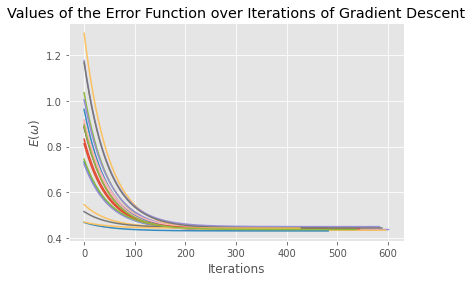

In [180]:
for error in errorsGD:
    plt.plot(error)
    plt.xlabel("Iterations")
    plt.ylabel("$E(\omega)$")
    plt.title("Values of the Error Function over Iterations of Gradient Descent");

__Plot $E(\omega)$ against the number of iterations of Stochastic Gradient Descent__

In [181]:
errorsSGD = np.array(LRSGD.errors, dtype=object)

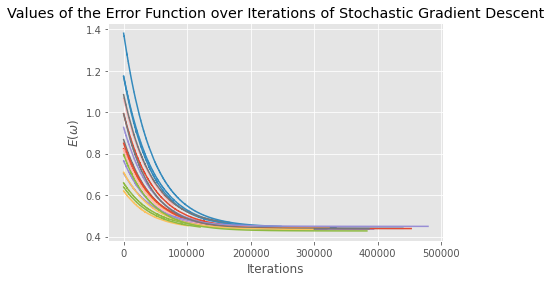

In [182]:
for error in errorsSGD:
    plt.plot(error)
    plt.xlabel("Iterations")
    plt.ylabel("$E(\omega)$")
    plt.title("Values of the Error Function over Iterations of Stochastic Gradient Descent");

-------------------------------------------------------------------------------------------------------------------------------